# Exploration 3. 카메라 스티커앱 만들기 첫걸음

본 과제는 opencv과 matplotlib을 이용한 얼굴 검출 작업으로 얼굴에 스티커를 적용 해 보는 작업이다. 이를 통하여 동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근에 대해 이해한다.

## 과제 목표
1. 얼굴 인식 카메라의 흐름 이해
2. diib 라이브러리 사용
3. 이미지 배열의 인덱싱 예외 처리
 
## 과제 평가 기준
1. 자기만의 카메라앱 기능 구현을 완수하였다.<br>
   원본에 스티커 사진이 정상적으로 합성되었다.<br>
2. 스티커 이미지를 정확한 원본 위치에 반영하였다.<br>
   정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.<br>
3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.<br>
   얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.

## 이미지 준비 작업
이미지 처리를 위한 opencv와 이미지 출력을 위한 matplotlib을 로드한 뒤, 준비한 이미지를 불러온다.

In [35]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
print("🌫🛸")

🌫🛸


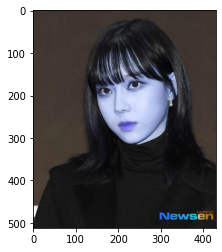

In [36]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지 로드
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)
plt.show()

출력된 이미지를 보면, 사진의 색감 표현에 이상이 있는 것을 확인할 수 있다. 이는 opencv의 특징으로, RGB 이미지 채널을 사용하는 matplotlib, diib와는 다르게 BGR 이미지 채널을 사용하기 때문이다. 그 이유는 opencv에서의 imread가 BGR의 순서로 numpy 배열에 채널별로 저장되지만, 이렇게 저장된 배열이 matplotlib에서는 RGB의 채널 순서로 읽히기 때문이다. 그러므로 아래와 같이 3차원 배열의 값 중 첫 번째와 세 번째 배열의 값을 서로 바꿔 주어야 한다.

### 참고 링크
* [이미지 다루기](https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html)
* [Python에서 이미지 채널 BGR 에서 RGB로 변환하기](https://tempdev.tistory.com/32)

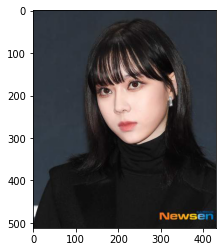

In [37]:
# plt.imshow 이전에 RGB 이미지로 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 얼굴 검출(face detection)
diib의 face detector를 이용하여 얼굴을 찾는다. face detector에서 사용되는 기법은 이미지에서 색상의 변화량을 나타내는 HOG(Histogram of Oriented Gradients)와 여러 개의 벡터를 구분하는 선형 분류기인 SVM(Support Vector Machine)이다. 
얼굴의 위치는 슬라이딩 윈도우(sliding window) 기법을 사용하는데, 이는 큰 이미지에서 여러 물체를 찾기 위해 전체 이미지를 적당한 영역으로 나눈 후, 각 영역에 대한 Localization network를 반복 적용하여 얼굴의 위치를 파악하는 방식이다. 이 경우에는 이미지가 크면 클 수록 긴 시간이 소요된다는 문제가 있다.

### 참고 링크
* [Histogram of Oriented Gradients](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html)
* [Histogram of oriented gradients(Wikipedia)](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)
* [Support-vector machine](https://en.wikipedia.org/wiki/Support-vector_machine)
* [딥러닝 Object Detection(3) - Sliding Window, Convolution](https://velog.io/@cha-suyeon/%EB%94%A5%EB%9F%AC%EB%8B%9D-Object-Detection-Sliding-Window-Convolution)

In [38]:
# diib를 활용한 hog detector 선언
detector_hog = dlib.get_frontal_face_detector()
print("🌫🛸")

🌫🛸


In [39]:
# detector_hog를 이용한 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")

🌫🛸


detector_hog의 두 번째 파라미터인 이미지 피라미드를 통해 정확히 얼굴을 검출할 수 있다. 이미지 피라미드(image pyramid)는 이미지의 크기를 단계적으로 변화(축소)시키는 과정에서 생성된 일련의 이미지 집합이라고 볼 수 있다. 

### 참고 링크
* [Image Pyramids](https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html)
* [Scale Space와 이미지 피라미드(image pyramid)](https://darkpgmr.tistory.com/137)

rectangles[[(118, 118) (304, 304)]]


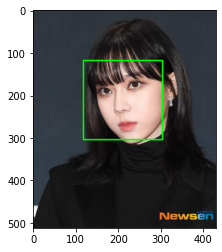

In [40]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 얼굴 랜드마크(face landmark) 찾기

스티커를 얼굴의 정확한 위치에 적용시키기 위해서는 이목구비의 위치를 정확히 파악하여야 한다. 이는 얼굴 검출의 결과물인 bounding box로 잘라낸 얼굴 이미지를 이용하여 이목구비의 위치를 추론하는 face landmark localization 기법을 이용한다.

In [62]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [61]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark 탐색
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print('\nlandmark의 좌표 출력')
print(list_landmarks) # landmark의 좌표들 출력
print(len(list_landmarks[0]))


landmark의 좌표 출력
[[(150, 203), (153, 222), (159, 241), (167, 257), (177, 273), (189, 287), (204, 300), (220, 311), (237, 312), (254, 306), (273, 292), (290, 275), (304, 255), (312, 235), (315, 213), (315, 189), (312, 166), (146, 178), (152, 171), (163, 170), (175, 171), (187, 174), (201, 167), (217, 159), (234, 152), (253, 150), (271, 155), (198, 187), (199, 201), (200, 215), (200, 229), (197, 242), (203, 244), (209, 244), (215, 241), (222, 238), (160, 193), (165, 185), (176, 184), (186, 193), (177, 196), (166, 197), (224, 185), (231, 172), (244, 169), (256, 173), (248, 181), (235, 184), (201, 272), (203, 266), (208, 261), (214, 262), (219, 260), (231, 262), (244, 266), (235, 276), (225, 282), (219, 284), (213, 284), (206, 279), (204, 272), (210, 269), (216, 269), (221, 268), (240, 266), (222, 270), (216, 271), (210, 271)]]
68


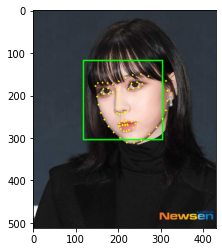

In [43]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

그림과 같이 얼굴의 랜드마크가 정확히 이미지에 출력이 된 것을 확인할 수 있다.

## 스티커 적용하기

<img src="https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-8.png"><br>
이제 랜드마크를 기준으로 코 위에 고양이 수염 스티커를 씌울 것이다. 먼저 코의 중심점의 좌표를 확인한다. 정확한 좌표를 파악하는 방법을 잘 알지 못해 이전 교육생들은 어떤 방식으로 진행했는지에 대해 참고했다.

### 참고 링크
* [project: 고양이 수염 스티커 만들기](https://github.com/ittapa/AIFFEL_LSG/blob/master/lms/01-EXPLORATION/E10-camera_sticker_app/02-project_cat.ipynb)

In [53]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(200, 229)
(x,y) : (200,136)
(w,h) : (187,187)


코의 중심점은 (220, 229)로 확인된다. 준비 해 둔 스티커 이미지를 읽어 적용한다.

In [54]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 187, 3)


수염의 이미지를 읽고 윗 단계에서 계산한 크기로 사이즈를 조정한 후, 원본 이미지에 스티커 이미지를 추가하기 위해 x, y 좌표를 조정한다.

In [55]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (107,-51)


y축 좌표의 값이 음수로 출력되는 문제가 발생하는데, 이는 스티커의 시작점이 얼굴 사진의 영역을 벗어났기 때문이다. opencv 데이터는 numpy의 ndarray 형태의 데이터를 사용하는데, 이는 음수 인덱스에 접근 불가능하기 때문에 음수에 대한 예외 처리가 필요하다. 

In [56]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (107,0)


-y의 크기만큼 스티커를 자른 후 top의 x와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계값으로 수정한다.

In [57]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
print("슝~")

슝~


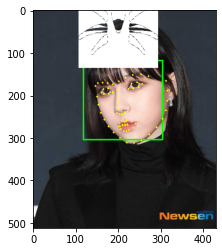

In [58]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 마치며
수학적인 이해가 부족하여 얼굴의 정확한 좌표를 파악하는 데 어려움이 있어 결과물을 내지 못했던 작업이었다. 전반적인 흐름은 어떻게 진행되는지 대략적으로 이해하였으나, 고양이 수염 이미지를 사진에 적용하는 과정에 있어서 어느 부분의 코드를 수정해야 하는지에 대한 이해가 부족했다. 이를 위해서는 수학적인 기법에 대한 이해가 필요하다고 느꼈다.